<a href="https://colab.research.google.com/github/hublun/Bayesian_Aggregation_Average_Data/blob/master/NumPyro_2024_1_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Using the OpenAI Library to Programmatically Access GPT-3.5-turbo!

This notebook was authored by [DRC Lab](http://www.dulun.com/)

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [3]:
!nvidia-smi

Mon Jan 22 14:56:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import jax

In [5]:
jax.devices()

[cuda(id=0)]

In [6]:
from jax import grad
import jax.numpy as jnp

def tanh(x):  # Define a function
  y = jnp.exp(-2.0 * x)
  return (1.0 - y) / (1.0 + y)

grad_tanh = grad(tanh)  # Obtain its gradient function
print(grad_tanh(1.0))   # Evaluate it at x = 1.0

0.4199743




---



In [7]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done




---



https://num.pyro.ai/en/stable/tutorials/bayesian_regression.html

In [8]:
import os

from IPython.display import set_matplotlib_formats
import jax.numpy as jnp

from jax import random, vmap

from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

plt.style.use("bmh")
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats("svg")

assert numpyro.__version__.startswith("0.13.2")

In [9]:
DATASET_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
dset = pd.read_csv(DATASET_URL, sep=";")
dset.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [10]:
dset.shape

(50, 13)

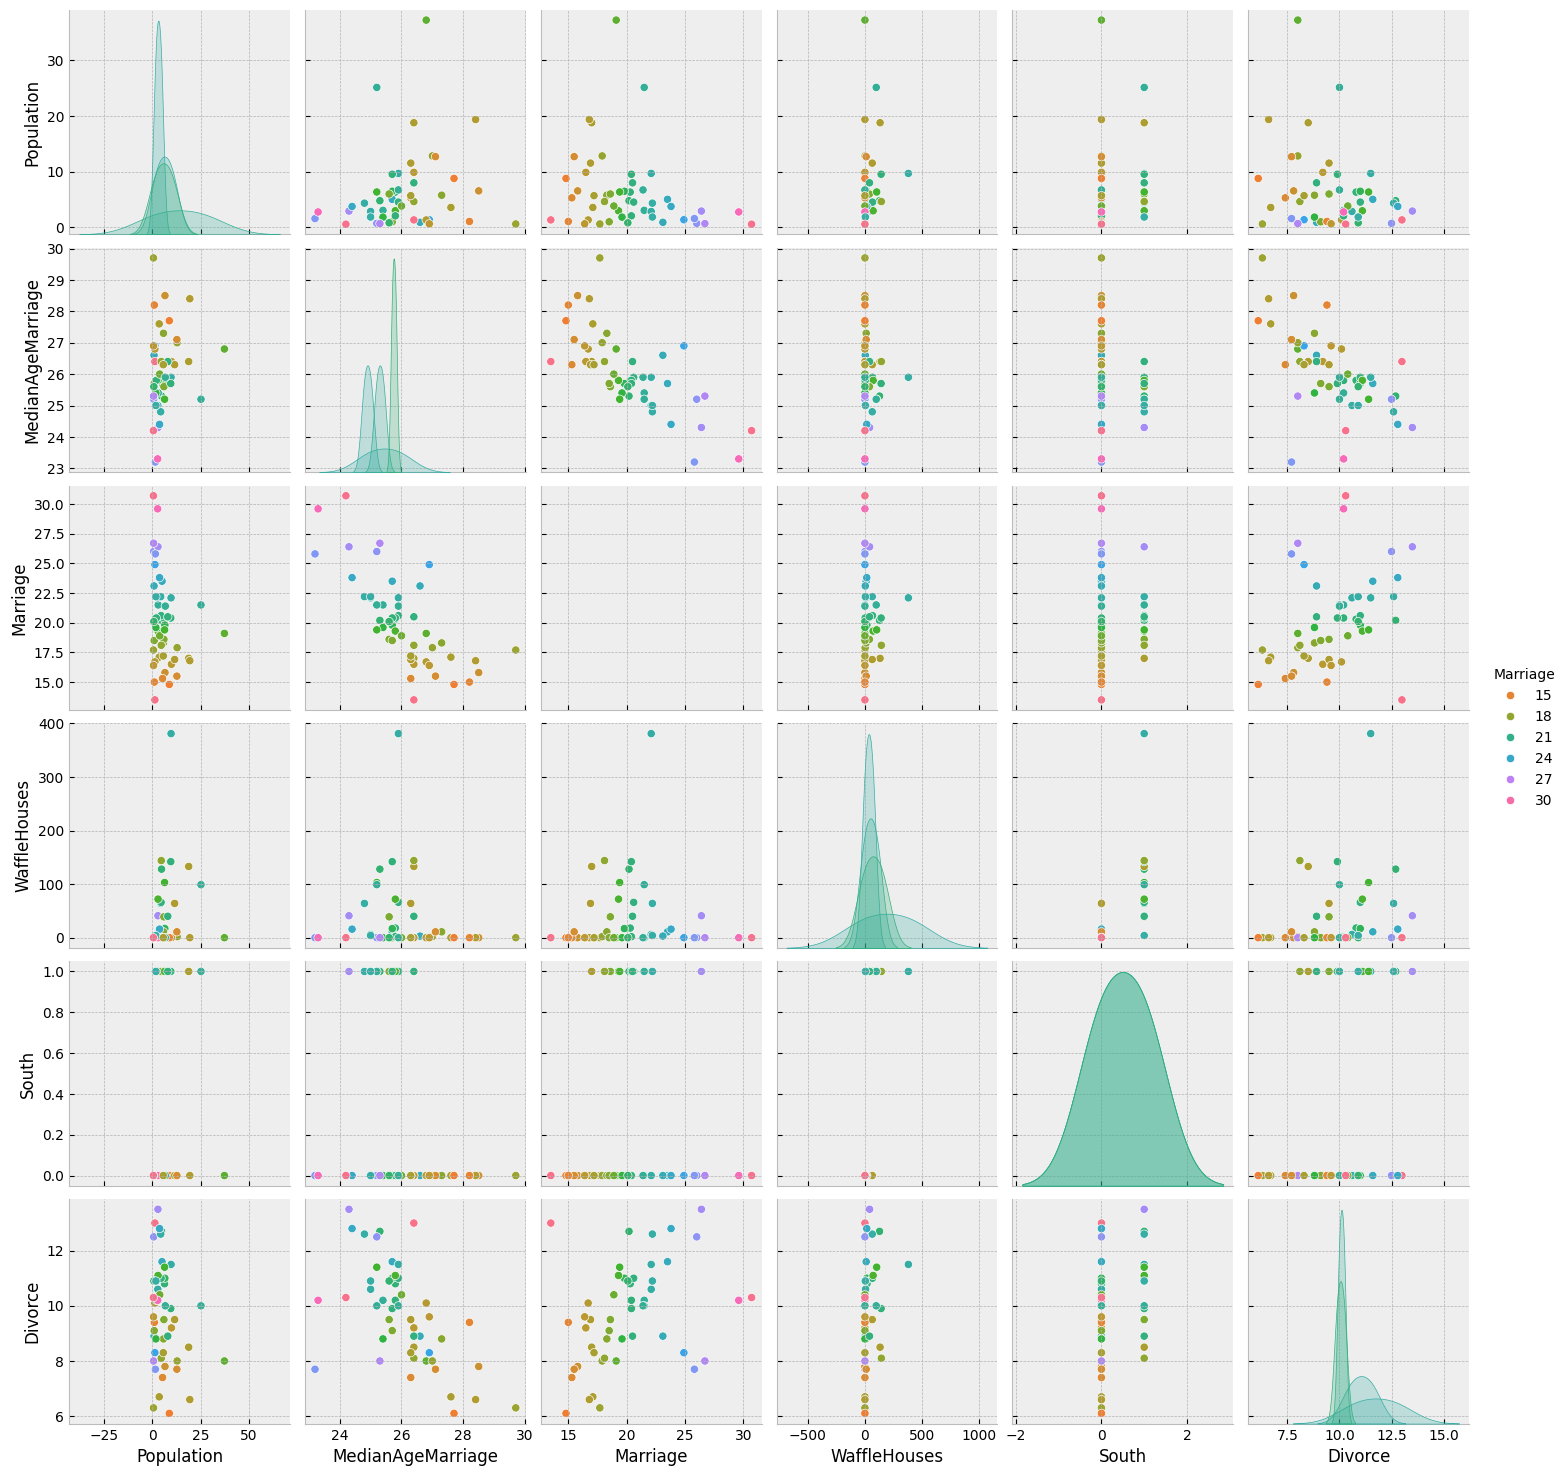

In [11]:
vars = [
    "Population",
    "MedianAgeMarriage",
    "Marriage",
    "WaffleHouses",
    "South",
    "Divorce",
]
sns.pairplot(dset, x_vars=vars, y_vars=vars, hue='Marriage', palette='husl');

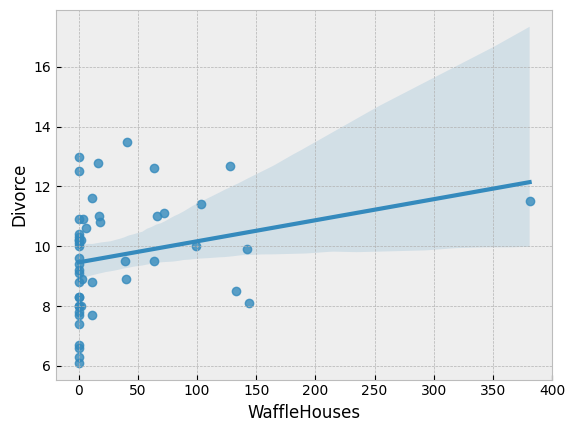

In [12]:
sns.regplot(x="WaffleHouses", y="Divorce", data=dset);

In [13]:
standardize = lambda x: (x - x.mean()) / x.std()

dset["AgeScaled"] = dset.MedianAgeMarriage.pipe(standardize)
dset["MarriageScaled"] = dset.Marriage.pipe(standardize)
dset["DivorceScaled"] = dset.Divorce.pipe(standardize)

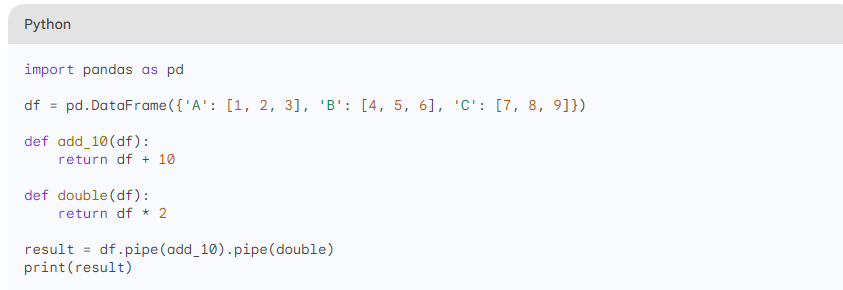

A sample statement makes this a stochastic function that samples some latent parameters from a prior distribution

In [14]:
def model(marriage=None, age=None, divorce=None):
    a = numpyro.sample("a", dist.Normal(0.0, 0.2)) # intercept
    M, A = 0.0, 0.0
    if marriage is not None:
        bM = numpyro.sample("bM", dist.Normal(0.0, 0.5))
        M = bM * marriage # beta 1
    if age is not None:
        bA = numpyro.sample("bA", dist.Normal(0.0, 0.5)) # beta 2
        A = bA * age
    sigma = numpyro.sample("sigma", dist.Exponential(1.0)) # non-negative
    mu = a + M + A
    numpyro.sample("obs", dist.Normal(mu, sigma), obs=divorce)

In [15]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)

mcmc.run(
    rng_key_, marriage=dset.MarriageScaled.values, divorce=dset.DivorceScaled.values
)


sample: 100%|██████████| 3000/3000 [00:16<00:00, 186.66it/s, 3 steps of size 8.31e-01. acc. prob=0.90]


`We notice that the progress bar gives us online statistics on the acceptance probability, step size and number of steps taken per sample while running NUTS. In particular, during warmup, we adapt the step size and mass matrix to achieve a certain target acceptance probability which is 0.8, by default. We were able to successfully adapt our step size to achieve this target in the warmup phase.`

In [16]:
mcmc.print_summary()
samples_1 = mcmc.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.01      0.11      0.00     -0.18      0.19   1519.84      1.00
        bM      0.35      0.13      0.35      0.16      0.58   2136.38      1.00
     sigma      0.95      0.10      0.94      0.78      1.11   1855.75      1.00

Number of divergences: 0


To look at our regression fit, let us plot the regression line using our posterior estimates for the regression parameters, along with the 90% Credibility Interval (CI). Note that the hpdi function in NumPyro’s diagnostics module can be used to compute CI. In the functions below, note that the collected samples from the posterior are all along the leading axis.

In [17]:
x = jnp.array([3, 1, 4, 2])
indices = jnp.argsort(x)  # indices = [1, 3, 0, 2]
sorted_x = x[indices]  # sorted_x = [1, 2, 3, 4]

sorted_x

Array([1, 2, 3, 4], dtype=int32)

In [18]:
def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    divorce = dset.DivorceScaled.values[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(marriage, mean)
    ax.plot(marriage, divorce, "o")
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax

In [19]:
samples_1['a'].shape

(2000,)

In [20]:
jnp.expand_dims(samples_1['a'], -1).shape

(2000, 1)

In [21]:
# Compute empirical posterior distribution over mu
posterior_mu = (
    jnp.expand_dims(samples_1["a"], -1)
    + jnp.expand_dims(samples_1["bM"], -1) * dset.MarriageScaled.values
)

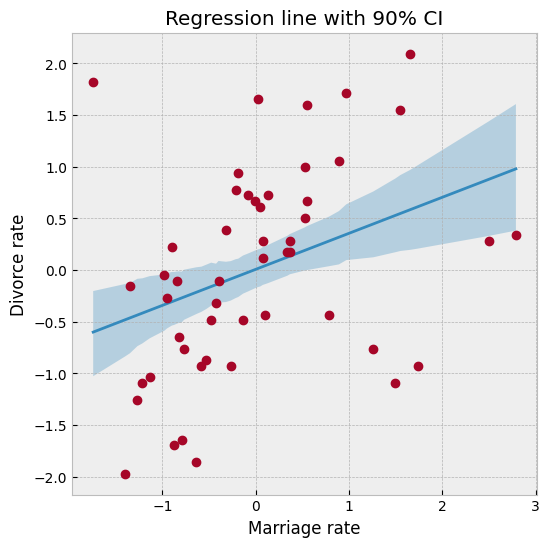

In [22]:
mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(dset.MarriageScaled.values, mean_mu, hpdi_mu)
ax.set(
    xlabel="Marriage rate", ylabel="Divorce rate", title="Regression line with 90% CI"
);

In [23]:
#We can see from the plot, that the CI broadens towards the tails where the data is relatively sparse, as can be expected.

[Prior Predictive Checking](https://num.pyro.ai/en/stable/tutorials/bayesian_regression.html#Prior-Predictive-Distribution)

In [24]:
from numpyro.infer import Predictive

rng_key, rng_key_ = random.split(rng_key)

prior_predictive = Predictive(model, num_samples=100)

prior_predictions = prior_predictive(rng_key_, marriage=dset.MarriageScaled.values)[
    "obs"
]


In [25]:
prior_predictions.shape

(100, 50)

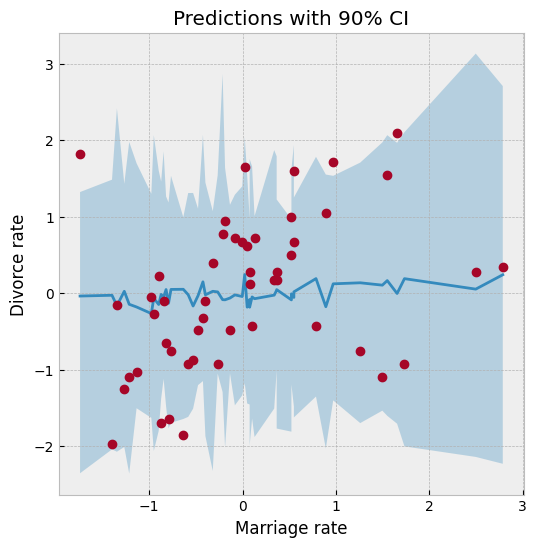

In [26]:
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)

ax = plot_regression(dset.MarriageScaled.values, mean_prior_pred, hpdi_prior_pred)
ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Predictions with 90% CI");

## [Posterior Predictive Check](https://num.pyro.ai/en/stable/tutorials/bayesian_regression.html#Posterior-Predictive-Distribution)

Let us now look at the posterior predictive distribution to see how our predictive distribution looks with respect to the observed divorce rates. To get samples from the posterior predictive distribution, we need to run the model by substituting the latent parameters with samples from the posterior. Note that by default we generate a single prediction for each sample from the joint posterior distribution, but this can be controlled using the num_samples argument.

In [27]:
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1) #  substituting the latent parameters with samples from the posterior
predictions = predictive(rng_key_, marriage=dset.MarriageScaled.values)["obs"]


In [28]:
predictions

Array([[-0.92835814,  0.45956832,  0.62220216, ...,  2.3725169 ,
        -0.05892673,  1.6490264 ],
       [ 0.26338297,  0.9927422 ,  0.35196337, ..., -0.9073915 ,
         0.13350761,  1.1448153 ],
       [ 0.9506678 ,  0.17832124, -0.4027779 , ...,  0.4998142 ,
        -1.0108113 ,  1.1506491 ],
       ...,
       [-0.7279529 ,  1.1480759 , -0.16590123, ...,  0.8775146 ,
        -1.1031033 , -0.508186  ],
       [-0.65508527,  0.10560089, -0.7041929 , ...,  0.7019983 ,
        -0.78610104,  2.0849786 ],
       [ 0.0310376 ,  0.17773283,  1.0255997 , ..., -0.01481643,
         0.12331003,  1.6692723 ]], dtype=float32)

In [29]:
df = dset.filter(["Location"])
df["Mean Predictions"] = jnp.mean(predictions, axis=0)
df.head()

,Location,Mean Predictions
0,Alabama,0.017423
1,Alaska,0.505819
2,Arizona,0.027567
3,Arkansas,0.605251
4,California,-0.078297


## [Predictive Utility With Effect Handlers](https://num.pyro.ai/en/stable/tutorials/bayesian_regression.html#Predictive-Utility-With-Effect-Handlers)

To remove the magic behind Predictive, let us see how we can combine effect handlers with the vmap JAX primitive to implement our own simplified predictive utility function that can do vectorized predictions.

In [30]:
def predict(rng_key, post_samples, model, *args, **kwargs):
    model = handlers.seed(handlers.condition(model, post_samples), rng_key)
    model_trace = handlers.trace(model).get_trace(*args, **kwargs)
    return model_trace["obs"]["value"]

The seed effect-handler is used to wrap a **stochastic function** with an initial
PRNGKey seed. When a sample statement inside the model is called, it uses the existing seed to sample from a distribution but this effect-handler also splits the existing key to ensure that future sample calls in the model use the newly split key instead. This is to prevent us from having to explicitly pass in a PRNGKey to each sample statement in the model.

The condition effect handler conditions the latent sample sites to certain values. In our case, we are conditioning on values from the **posterior distribution returned by MCMC**.

The trace effect handler runs the model and records the execution trace within an OrderedDict. This trace object contains execution metadata that is useful for computing quantities such as the log joint density.

In [31]:
# vectorize predictions via vmap
predict_fn = vmap(
    lambda rng_key, samples: predict(
        rng_key, samples, model, marriage=dset.MarriageScaled.values
    )
)

It should be clear now that the predict function simply runs the model by substituting the latent parameters with samples from the posterior (generated by the mcmc function) to generate predictions. Note the use of JAX’s auto-vectorization transform called vmap to vectorize predictions. Note that if we didn’t use vmap, we would have to use a native for loop which for each sample which is much slower. Each draw from the posterior can be used to get predictions over all the 50 states. When we vectorize this over all the samples from the posterior using vmap, we will get a predictions_1 array of shape (num_samples, 50). We can then compute the mean and 90% CI of these samples to plot the posterior predictive distribution. We note that our mean predictions match those obtained from the Predictive utility class.

In [32]:
# Using the same key as we used for Predictive - note that the results are identical.

predictions_1 = predict_fn(random.split(rng_key_, num_samples), samples_1)

mean_pred = jnp.mean(predictions_1, axis=0)
df = dset.filter(["Location"])
df["Mean Predictions"] = mean_pred
df.head()

,Location,Mean Predictions
0,Alabama,0.017423
1,Alaska,0.505819
2,Arizona,0.027567
3,Arkansas,0.605251
4,California,-0.078297


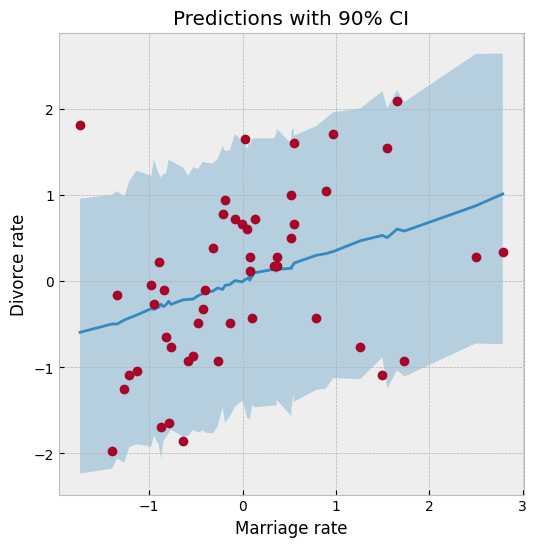

In [33]:
hpdi_pred = hpdi(predictions_1, 0.9)

ax = plot_regression(dset.MarriageScaled.values, mean_pred, hpdi_pred)
ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Predictions with 90% CI");

We have used the same plot_regression function as earlier. We notice that our CI for the predictive distribution is much broader as compared to the last plot due to the additional noise introduced by the sigma parameter. Most data points lie well within the 90% CI, which indicates a good fit.